## Best Fit
   
Determine best fit model for daily deaths
   
Code taken from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

In [2]:
import os, sys

projdir = os.path.realpath(os.path.join(sys.path[0], '..'))

Text(0, 0.5, 'Frequency')

<Figure size 864x576 with 0 Axes>

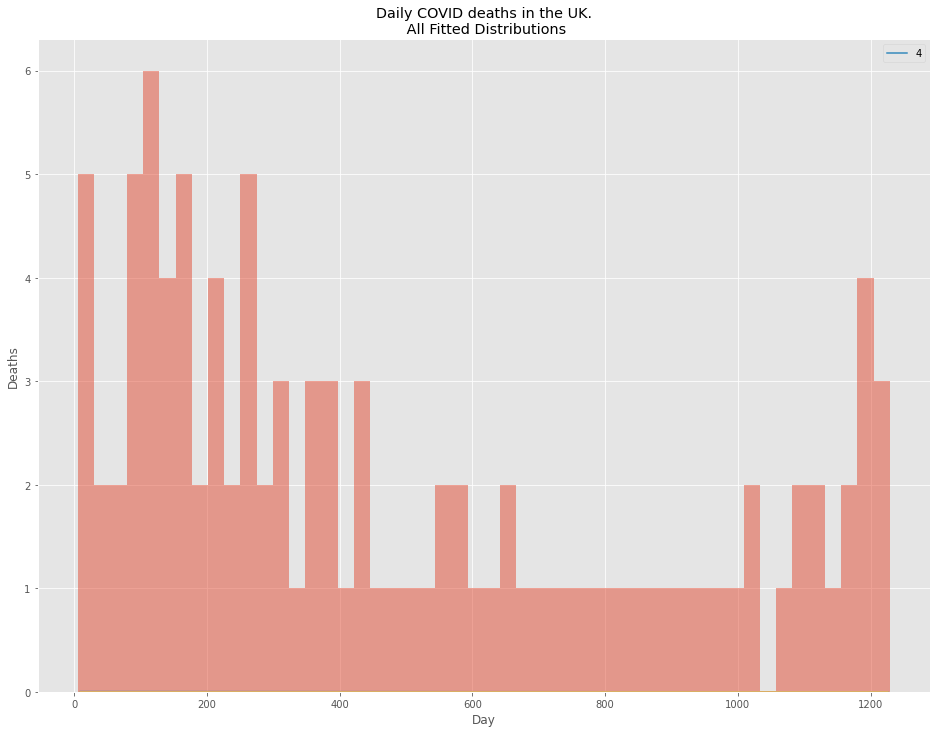

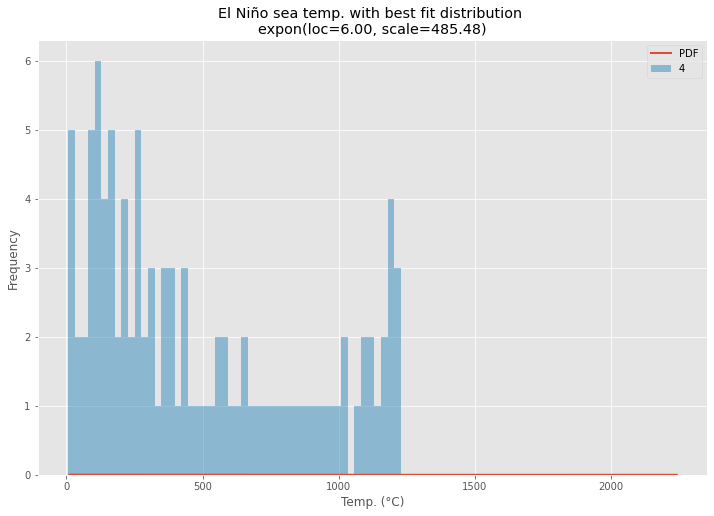

In [10]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
#data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
data = pd.read_csv(os.path.join(projdir, 'data', 'daily_covid_deaths.csv'))

# Plot for comparison
plt.figure(figsize=(12,8))
#ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
ax = data.plot(kind='hist', bins=50, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Daily COVID deaths in the UK.\n All Fitted Distributions')
ax.set_xlabel(u'Day')
ax.set_ylabel('Deaths')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.round_ is deprecated and will be removed in SciPy 2.0.0, use numpy.round_ instead
  
/opt/conda/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


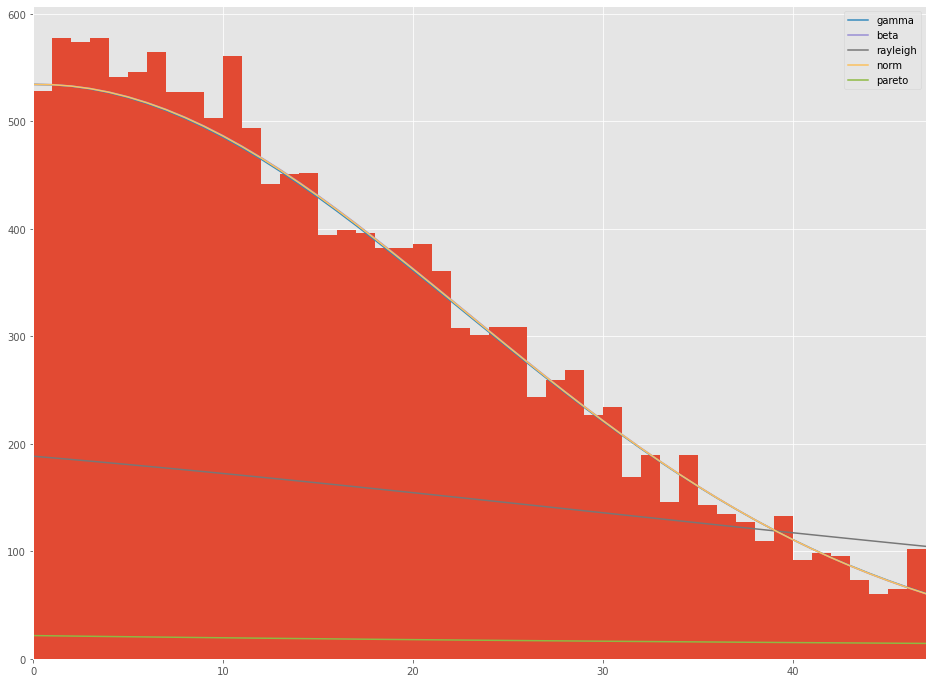

In [11]:
import matplotlib.pyplot as plt
import scipy
import scipy.stats
size = 30000
x = scipy.arange(size)
y = scipy.int_(scipy.round_(scipy.stats.vonmises.rvs(5,size=size)*47))
h = plt.hist(y, bins=range(48))

dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,47)
plt.legend(loc='upper right')
plt.show()

https://stackoverflow.com/questions/36795949/python-testing-if-my-data-follows-a-lognormal-distribution

In [5]:
import scipy

listofdata = []

with open(os.path.join(projdir, 'data', 'daily_covid_deaths.csv')) as f:
    line = f.readline()
    while line:
        listofdata.append(int(line))
        line = f.readline()

shape, location, scale = scipy.stats.lognorm.fit(listofdata)
print(shape, location, scale)

mu, sigma = np.log(scale), shape
print(mu, sigma)

scipy.stats.kstest(listofdata, "lognorm", scipy.stats.lognorm.fit(listofdata))

6.0260796229474405 3.999999999999999 3.7272526971737636
1.3156714199625075 6.0260796229474405


KstestResult(statistic=0.5976784959977458, pvalue=2.433154254584929e-35)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html

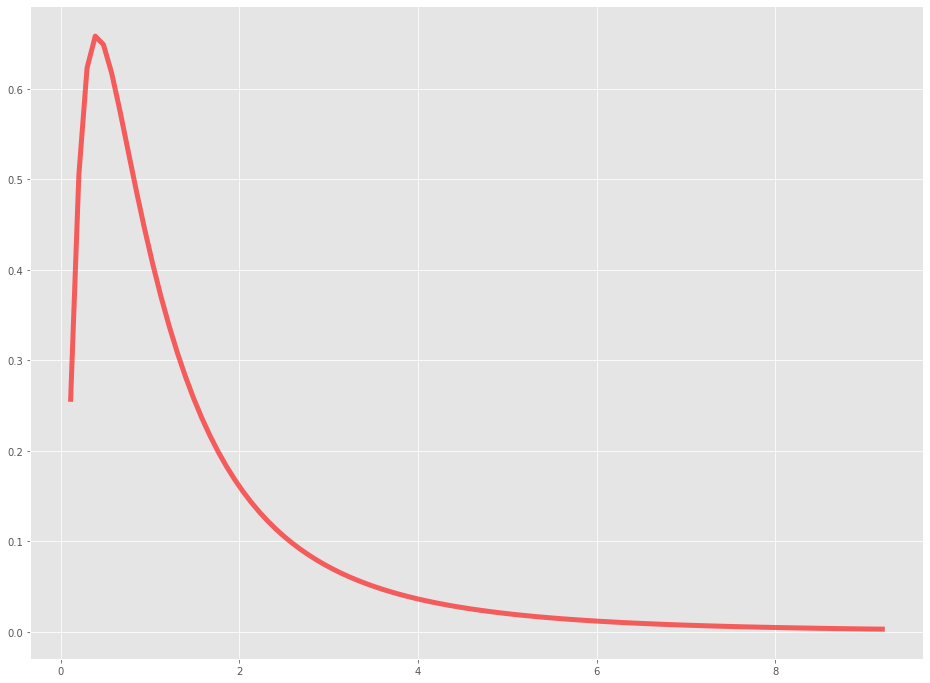

In [29]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

s = 0.954
mean, var, skew, kurt = lognorm.stats(s, moments='mvsk')

x = np.linspace(lognorm.ppf(0.01, s), lognorm.ppf(0.99, s), 100)
ax.plot(x, lognorm.pdf(x, s), 'r-', lw=5, alpha=0.6, label='lognorm pdf')

https://stackoverflow.com/questions/53177243/fitting-a-lognormal-distribution-to-the-data-and-performing-kolmogorov-smirnov-t

In [15]:
import numpy as np
from scipy.stats import lognorm, kstest

x = []

with open(os.path.join(projdir, 'data', 'daily_covid_deaths.csv')) as f:
    line = f.readline()
    while line:
        x.append(int(line))
        line = f.readline()

sigma, loc, scale = lognorm.fit(x, floc=0)

mu = np.log(scale)

print("mu    = %9.5f" % mu)
print("sigma = %9.5f" % sigma)

stat, p = kstest(x, 'lognorm', args=(sigma, 0, scale), alternative='two-sided')
print("KS Test:")
print("stat    = %9.5f" % stat)
print("p-value = %9.5f" % p)


mu    =   5.69750
sigma =   1.21665
KS Test:
stat    =   0.12217
p-value =   0.08744
